In [2]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import spacy
import nltk

In [3]:
df = pd.read_csv('CNN_Articels_clean.csv')

In [4]:
df.head()

,Index,Author,Date published,Category,Section,Url,Headline,Description,Keywords,Second headline,Article text
0,0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
1,1,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,https://www.cnn.com/2021/05/12/world/ironhand-...,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
2,2,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robo...,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,3,Kathryn Vasel,2022-03-18 14:37:21,business,success,https://www.cnn.com/2022/03/18/success/pandemi...,"Two years later, remote work has changed milli...",Here's a look at how the pandemic reshaped peo...,"success, Two years later, remote work has chan...","Two years later, remote work has changed milli...",The pandemic thrust the working world into a n...
4,4,"Paul R. La Monica, CNN Business",2022-03-19 11:41:08,business,investing,https://www.cnn.com/2022/03/19/investing/march...,Why March is so volatile for stocks - CNN,March Madness isn't just for college basketbal...,"investing, Why March is so volatile for stocks...",Why March is so volatile for stocks,New York (CNN Business)March Madness isn't jus...


### We'll take a look at the distribution of categories and sections as labels for classification.

In [48]:
gb_cat = df.groupby('Category').size().reset_index(name='Count')

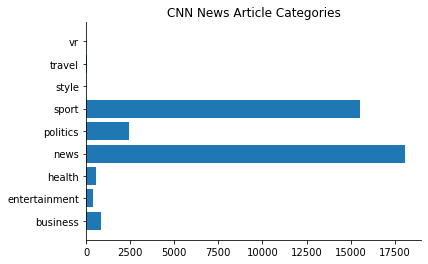

In [50]:
fig, ax = plt.subplots()

ax.barh(gb_cat['Category'], gb_cat['Count'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('CNN News Article Categories')
plt.show()

In [185]:
gb_cat

,Category,Count
0,business,854
1,entertainment,413
2,health,557
3,news,18077
4,politics,2461
5,sport,15542
6,style,1
7,travel,39
8,vr,5


In [51]:
gb_sec = df.groupby('Section').size().reset_index(name='Count')

In [72]:
temp_gb_sec = gb_sec[gb_sec['Count'] > 50]

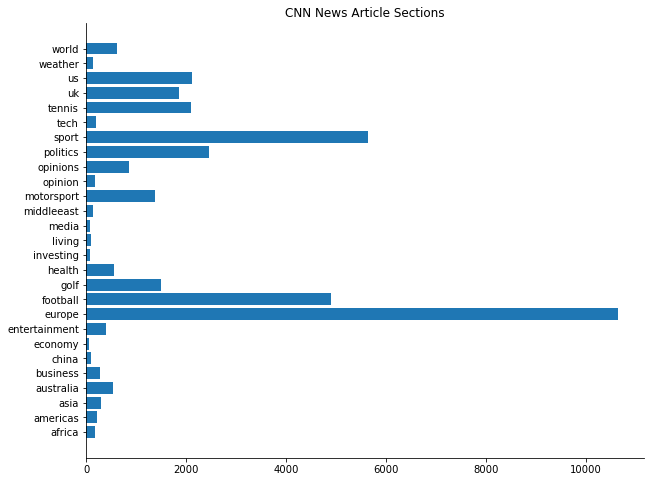

In [73]:
fig, ax = plt.subplots(figsize=(10,8))

ax.barh(temp_gb_sec['Section'], temp_gb_sec['Count'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('CNN News Article Sections')
plt.show()

In [192]:
sum(gb_sec[gb_sec['Count'] <= 50]['Count'])

302

### Data cleaning and headline tokenization

In [160]:
import string
import re
from collections import Counter
from nltk.corpus import stopwords

nlp = spacy.load('en_core_web_sm')
stopwords = stopwords.words('english')

In [195]:
stopwords.append('cnn') # add cnn to stopwords
stopwords.append(' ') # add space to stopwords..

In [196]:
[t.lemma_ for t in nlp(df.iloc[1]['Headline']) if t.lemma_ not in stopwords]

['Bioservo',
 "'s",
 'robotic',
 "'",
 'Ironhand',
 "'",
 'could',
 'protect',
 'factory',
 'worker',
 'injury',
 '-',
 'CNN']

In [197]:
headlines = []

for idx in tqdm(range(len(df))):
    head = df.iloc[idx]['Headline']
    
    head = re.sub("[^A-Za-z']+", ' ', head.replace('<br />', ' ')).lower()
    head = head.translate(str.maketrans('', '', string.punctuation))
    
    tokenized_headline = [t.lemma_ for t in nlp(head) if t.lemma_ not in stopwords]
    headlines.append(tokenized_headline)

  0%|          | 0/37949 [00:00<?, ?it/s]

In [198]:
df['clean_headline'] = headlines

### We'll also take a look at the top 25 most common words that appear in the headlines for each category.

In [199]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2)

In [200]:
sport_df = train_df[train_df['Category']=='sport']

sport_word_freq = Counter([t for headline in sport_df['clean_headline'] for t in headline]).most_common()

sport_word_freq_dict = dict(sport_word_freq)

sport_word_df = pd.DataFrame(sport_word_freq_dict.items(), columns=['word', 'count'])

In [201]:
sport_word_df[0:25][::-1]

,word,count
24,australian,276
23,year,284
22,wood,286
21,djokovic,290
20,make,310
19,f,338
18,record,341
17,game,342
16,manchester,349
15,team,350


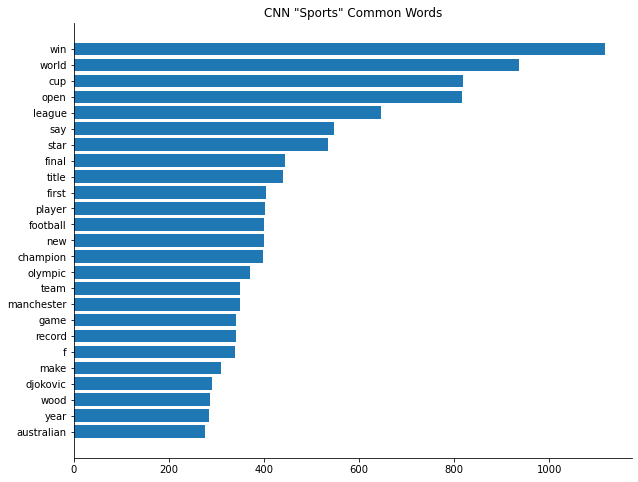

In [202]:
fig, ax = plt.subplots(figsize=(10,8))

ax.barh(sport_word_df['word'][0:25][::-1], sport_word_df['count'][0:25][::-1])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('CNN "Sports" Common Words')
plt.show()

In [203]:
news_df = train_df[train_df['Category']=='news']

news_word_freq = Counter([t for headline in news_df['clean_headline'] for t in headline]).most_common()

news_word_freq_dict = dict(news_word_freq)

news_word_df = pd.DataFrame(news_word_freq_dict.items(), columns=['word', 'count'])

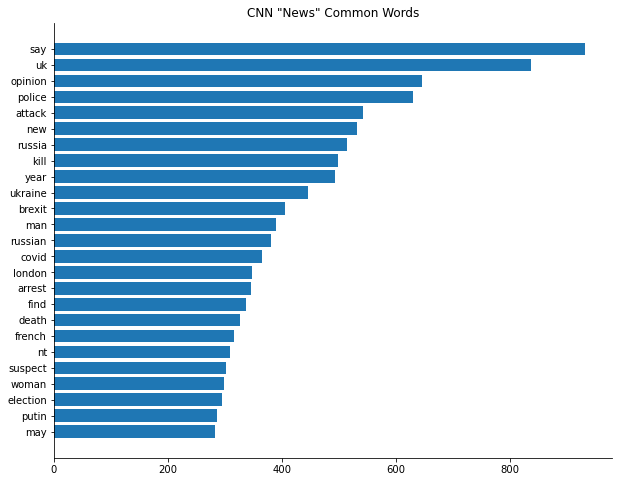

In [204]:
fig, ax = plt.subplots(figsize=(10,8))

ax.barh(news_word_df['word'][0:25][::-1], news_word_df['count'][0:25][::-1])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('CNN "News" Common Words')
plt.show()

In [205]:
politics_df = train_df[train_df['Category']=='politics']

politics_word_freq = Counter([t for headline in politics_df['clean_headline'] for t in headline]).most_common()

politics_word_freq_dict = dict(politics_word_freq)

politics_word_df = pd.DataFrame(politics_word_freq_dict.items(), columns=['word', 'count'])

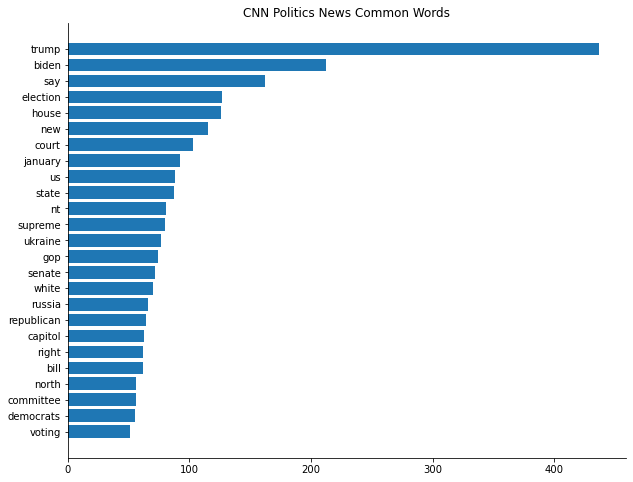

In [206]:
fig, ax = plt.subplots(figsize=(10,8))

ax.barh(politics_word_df['word'][1:26][::-1], politics_word_df['count'][1:26][::-1])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('CNN Politics News Common Words')
plt.show()

In [207]:
entertain_df = train_df[train_df['Category']=='entertainment']

entertain_word_freq = Counter([t for headline in entertain_df['clean_headline'] for t in headline]).most_common()

entertain_word_freq_dict = dict(entertain_word_freq)

entertain_word_df = pd.DataFrame(entertain_word_freq_dict.items(), columns=['word', 'count'])

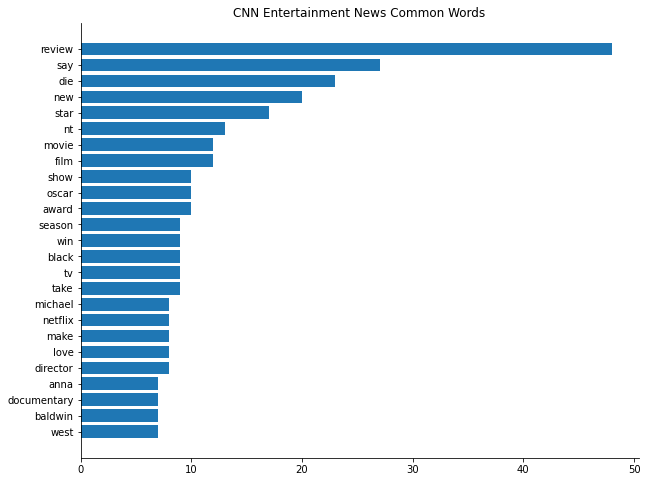

In [208]:
fig, ax = plt.subplots(figsize=(10,8))

ax.barh(entertain_word_df['word'][0:25][::-1], entertain_word_df['count'][0:25][::-1])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('CNN Entertainment News Common Words')
plt.show()